# Матрица доступности

- Тут вариант как-то собирать это все для контекста + сценария из дорог, но я пока не знаю, как. 
- Поэтому промежуточный вариант: матрица расстояний с переводом `метров` в `минуты`.

In [7]:
import geopandas as gpd
import pandas as pd

In [8]:
SCENARIO_ID = 835

In [9]:
from prostor.fetchers import scenarios

PROJECT_ID = scenarios.get_scenario(SCENARIO_ID)['project']['project_id']
PROJECT_ID

120

## 1. Объединение кварталов контекста и сценария

Читаем кварталы контекста

In [10]:
context_blocks_gdf = pd.read_pickle('./data/context_blocks.pickle')
context_blocks_gdf['is_project'] = False
crs = context_blocks_gdf.crs

Читаем кварталы сценария

In [11]:
scenario_blocks_gdf = pd.read_pickle('./data/scenario_blocks.pickle').to_crs(crs)
scenario_blocks_gdf['is_project'] = True

Объединяем одно с другим

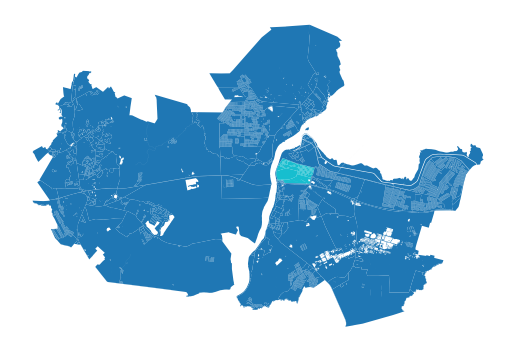

In [12]:
blocks_gdf = pd.concat([scenario_blocks_gdf, context_blocks_gdf]).reset_index(drop=True)
blocks_gdf.plot('is_project').set_axis_off()

## 2. Назначение доп параметров

### 2.1. Площадь

In [13]:
blocks_gdf['site_area'] = blocks_gdf.area

### 2.2. `parent` из контекста

Чтобы затем можно было фильтровать по ним в модулях при необходимости

In [14]:
from prostor.fetchers import projects, territories

def get_context_territories(project_id : int) -> gpd.GeoDataFrame:
    project = projects.get_project(project_id)
    context_ids = project['properties']['context']
    data = [{
        'parent': territory_id,
        'geometry': territories.get_territory_geometry(territory_id)
    } for territory_id in context_ids]
    gdf = gpd.GeoDataFrame(data=data, crs=4326)
    return gdf

context_territories_gdf = get_context_territories(PROJECT_ID)

In [15]:
from blocksnet.blocks.assignment import assign_objects

context_territories_gdf = context_territories_gdf.to_crs(blocks_gdf.crs)

assign_gdf = assign_objects(blocks_gdf, context_territories_gdf.rename(columns={'parent':'name'}))

In [16]:
assign_gdf.head()

,geometry,46,43,113,114,111,name,share
0,"POLYGON ((390910.954 6643711.722, 390543.793 6...",0.0,0.0,1.000000,0.000000,0.000000,113,1.000000
1,"POLYGON ((390477.466 6643522.257, 390543.793 6...",0.0,0.0,0.311332,0.688673,0.000000,114,0.688673
2,"POLYGON ((389502.756 6643847.197, 389551.22 66...",0.0,0.0,1.000000,0.000000,0.000000,113,1.000000
3,"POLYGON ((389551.22 6644060.777, 389502.756 66...",0.0,0.0,0.998810,0.000000,0.001192,113,0.998810
4,"POLYGON ((389551.22 6644060.777, 389599.698 66...",0.0,0.0,1.000000,0.000000,0.000000,113,1.000000


In [17]:
blocks_gdf['parent'] = assign_gdf['name'].astype(int)

## 3. Считаем матрицы

### 3.1. Матрица доступности

In [18]:
from blocksnet.relations import calculate_distance_matrix

SPEED = 5 * 1_000 / 60

def get_accessibility_matrix(blocks : gpd.GeoDataFrame) -> pd.DataFrame:
  crs = blocks.estimate_utm_crs()
  dist_mx = calculate_distance_matrix(blocks.to_crs(crs))
  return dist_mx // SPEED

In [19]:
acc_mx = get_accessibility_matrix(blocks_gdf)
acc_mx.head()

,0,1,2,3,4,5,6,7,8,9,...,3471,3472,3473,3474,3475,3476,3477,3478,3479,3480
0,0.0,4.0,16.0,27.0,15.0,22.0,15.0,16.0,18.0,36.0,...,95.0,94.0,94.0,94.0,94.0,89.0,89.0,89.0,87.0,87.0
1,4.0,0.0,13.0,25.0,14.0,20.0,14.0,15.0,17.0,33.0,...,92.0,92.0,91.0,91.0,92.0,86.0,86.0,86.0,85.0,84.0
2,16.0,13.0,0.0,11.0,2.0,6.0,4.0,6.0,7.0,20.0,...,100.0,99.0,99.0,99.0,100.0,93.0,93.0,93.0,92.0,92.0
3,27.0,25.0,11.0,0.0,13.0,8.0,14.0,15.0,14.0,9.0,...,103.0,102.0,102.0,102.0,103.0,95.0,95.0,96.0,94.0,95.0
4,15.0,14.0,2.0,13.0,0.0,6.0,1.0,3.0,5.0,20.0,...,102.0,101.0,101.0,101.0,102.0,95.0,95.0,95.0,94.0,94.0


### 3.2. Матрица расстояний

Считается несложно, пусть будет для буферов.

In [20]:
from blocksnet.relations import calculate_distance_matrix

dist_mx = calculate_distance_matrix(blocks_gdf)
dist_mx.head()

,0,1,2,3,4,5,6,7,8,9,...,3471,3472,3473,3474,3475,3476,3477,3478,3479,3480
0,0,362,1345,2329,1321,1859,1323,1351,1555,3020,...,7940,7888,7852,7874,7910,7464,7439,7463,7326,7300
1,362,0,1146,2090,1178,1703,1213,1293,1493,2820,...,7728,7676,7643,7666,7705,7231,7209,7233,7102,7083
2,1345,1146,0,995,222,577,342,542,629,1680,...,8347,8292,8270,8296,8346,7785,7774,7797,7684,7690
3,2329,2090,995,0,1098,696,1168,1299,1212,790,...,8593,8536,8525,8553,8613,7977,7977,8000,7904,7935
4,1321,1178,222,1098,0,538,121,320,424,1711,...,8534,8479,8456,8481,8530,7978,7966,7989,7874,7878


## Результат

- Объединенный слой кварталов сценария и контекста с доп столбцами:
    - `is_project : bool`
    - `site_area : float`
    - `parent : int`
- Матрицу доступности в `минутах`.
- Матрица расстояний в `метрах`.

In [21]:
blocks_gdf.to_pickle('./data/blocks.pickle')
acc_mx.to_pickle('./data/acc_mx.pickle')
dist_mx.to_pickle('./data/dist_mx.pickle')